In [1]:
import glob
import os
from common.lora_resize import change_lora_rank
from tqdm import tqdm
import torch

def aggregate_loras(path, rank):
    files = glob.glob(f"{path}/**/lora_layers_new.pth", recursive=True)
    loras = []
    for f in tqdm(files):
        # basically runs svd on it, this ensures down/up weights are balanced
        state_dict = torch.load(f, map_location="cpu")
        loras.append(state_dict)
    return loras


In [1]:
from discover_lora_diffusion.models import LoraDiffusion, DiT
import diffusers
import torch
from tqdm import tqdm 

from common.utils import make_weight_vector, recover_lora, convert_to_multi

lora_bundle = torch.load('/home/ubuntu/AutoLoRADiscovery/lora_bundle_for_model.pt')

_, weight_dict = make_weight_vector(lora_bundle[0])

lora_diffusion = DiT(
    total_dim=1_365_504,
    dim = 1536,
    num_tokens=889,
    time_dim = 384,
    depth=12,
    num_heads=16,
    mlp_ratio=4.0,
)

scheduler = diffusers.DDIMScheduler.from_config("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
state_dict = torch.load('/home/ubuntu/AutoLoRADiscovery/discover_lora_diffusion/diffusion_lora/checkpoint-8000')
lora_diffusion.load_state_dict(state_dict)
lora_diffusion = lora_diffusion.cuda().to(torch.float16)


/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/lib/python3.11/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible

In [2]:
latents = torch.randn(1, 1_365_504).cuda().to(torch.float16)
scheduler.set_timesteps(100)

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        pred = lora_diffusion(latents, t=t.unsqueeze(0).cuda().half())
        latents = scheduler.step(pred, t, latents, return_dict=False)[0]

latents = latents * 0.0152

100%|██████████| 100/100 [00:01<00:00, 65.49it/s]


In [3]:
state_dict = recover_lora(latents, weight_dict)
state_dict = convert_to_multi(state_dict, idx=0)

In [4]:
import diffusers
from common.loras import patch_lora

pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.safety_checker=None

lora_layers = [
        "attn2.to_q", 
        "attn2.to_k", 
        "attn2.to_v", 
        "attn2.to_out",
        # "proj_in",
        # "proj_out",
        # "norm",
        #  "ff", 
]
lora_layers_te = [
    "final_layer_norm",
    "7",
    "8",
    "9",
    "10",
    "11"
]

patch_lora(pipe.unet, rank=8, included_terms=lora_layers)
patch_lora(pipe.text_encoder, rank=8, included_terms=lora_layers_te)

missing, unexpected = pipe.unet.load_state_dict(state_dict, strict=False)
missing, unexpected = pipe.text_encoder.load_state_dict(state_dict, strict=False)
pipe = pipe.to("cuda", torch.float16)


/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s]


In [21]:
images = pipe("a photo of a sks person", height=640, width=640).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 16.43it/s]


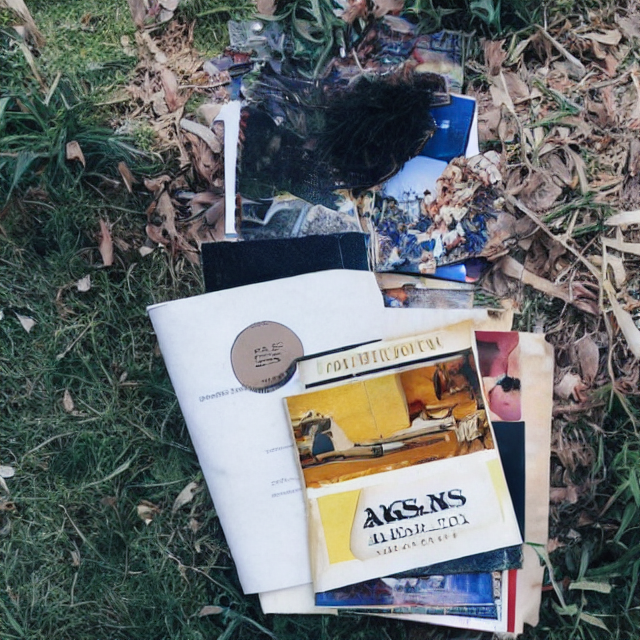

In [22]:
images